# MostlyAI SDK Tutorial — Hands-On continuation

In this second part we'll focus on two important topics where synthetic data can make a difference: privacy and, if time permits, fairness. 

## Differentially Private Synthetic Data

Regulations and privacy concerns can hinder data availability and usage. Synthetic data has the potential of helping overcome this issue by
- enabling data sharing, internally and externally ([here's](https://tools.eeb.eurac.edu/epc_clustering/piemonte/) an example)
- enabling data retention beyond legal periods.

MOSTLYAI SDK implements several privacy mechanisms such as value protection or overfitting prevention (more information [here](https://docs.mostly.ai/concepts/privacy-protection)), but in this tutorial we'll focus on **differential privacy** (DP).

### Differential Privacy TL;DR

Roughly speaking, DP is a mathematical framework for sharing sensitive data that preserves general statistics while limiting informations leaks about specific individuals.
An important hyperparameter in DP is ε, which represents the privacy budget. Smaller ε values are associated with stronger privacy, which comes at the cost of harming accuracy a bit. We'll delve into this in a moment.

How it is applied in MOSTLYAI SDK:
- DP is used to define value bounds for each column, with an ε budget that is evenly split across columns,
- Trainig the model with a differentially private gradient descent mechanism called DP-SGD with some budget ε,
- The total privacy budget is the sum of both budgets.

See [DifferentialPrivacyConfig](https://mostly-ai.github.io/mostlyai/api_domain/#mostlyai.sdk.domain.DifferentialPrivacyConfig) for all available configuration parameters.


### Load Original Data

We'll work with a different dataset now, the `census` dataset which contains demographic information about a population.

In [1]:
import pandas as pd

# fetch original data
df_original = pd.read_csv("https://github.com/mostly-ai/public-demo-data/raw/dev/census/census.csv.gz")
df_original.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [2]:
df_original.head(3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [3]:
df_original.shape

(48842, 15)

In [4]:
from sklearn.model_selection import train_test_split

df, df_ho = train_test_split(df_original, test_size=0.2, random_state=42)
df.shape, df_ho.shape

((39073, 15), (9769, 15))

### Train Generators with and without Differential Privacy

The goal of this section is to evaluate the impact that DP has in accuracy for different privacy budgets and mechanisms.

In [5]:
from mostlyai.sdk import MostlyAI

# initialize SDK
mostly = MostlyAI(local=True)

Initializing Synthetic Data SDK 5.2.4 in LOCAL mode 🏠

Connected to ]8;id=500386;file:///Users/mariana/mostlyai\/Users/mariana/]8;;\]8;id=105944;file:///Users/mariana/mostlyai\mostlyai]8;;\ with 16 GB RAM, 8 CPUs, 0 GPUs available

#### Train a generator without DP until fully converged

In [6]:
df = df.sample(10000)  # We take a smaller sample to speed up the training

In [7]:
g_no_dp = mostly.train(
    config={
        "name": "US Census without DP - full",
        "tables": [
            {
                "name": "census",
                "data": df,
            }
        ],
    },
    progress_bar=False,
)

Created generator dc9c5193-0198-4c9e-bd57-02ff99ee8f51

Started generator training

🎉 Your generator is ready! Use it to create synthetic data. Publish it so others can do the same.

#### Train generators with DP

Let's train generators with different values of ε.

In [8]:
dp_generators = []
epsilons = [0.5, 1.5, 2.5]
for epsilon in epsilons:
    g_dp = mostly.train(
        config={
            "name": f"Census with DP {epsilon}",
            "tables": [
                {
                    "name": "census",
                    "data": df,
                    "tabular_model_configuration": {
                        "differential_privacy": {
                            "max_epsilon": epsilon,
                        },
                    },
                }
            ],
        },
        progress_bar=False,
    )
    dp_generators.append(g_dp)


Created generator d8269ddb-d164-4100-87d3-8b547de71d7e

Started generator training

🎉 Your generator is ready! Use it to create synthetic data. Publish it so others can do the same.

Created generator 237cba4d-aecc-42f2-a991-142838f88e18

Started generator training

🎉 Your generator is ready! Use it to create synthetic data. Publish it so others can do the same.

Created generator 3f06bd38-fccf-46ab-aa88-0bb7bf8069a0

Started generator training

🎉 Your generator is ready! Use it to create synthetic data. Publish it so others can do the same.

#### How does the privacy budget affect the accuracy?

1. Generate synthetic datasets with each generator,
2. Measure its ML utility with the TSTR framework.

In [9]:
no_dp_gen = mostly.generate(g_no_dp, progress_bar=False)
no_dp_synth_dataset = no_dp_gen.data()

Created synthetic dataset 0c7cd58b-cd7e-4232-9b39-beda2ba8c348 with generator dc9c5193-0198-4c9e-bd57-02ff99ee8f51

Started synthetic dataset generation

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

In [10]:
dp_synth_datasets = [mostly.generate(g, progress_bar=False) for g in dp_generators]

Created synthetic dataset a119c283-ec1e-4cdb-99c4-9aca54549132 with generator d8269ddb-d164-4100-87d3-8b547de71d7e

Started synthetic dataset generation

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

Created synthetic dataset b546b138-6542-40f6-b156-e12f335327f2 with generator 237cba4d-aecc-42f2-a991-142838f88e18

Started synthetic dataset generation

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

Created synthetic dataset 23c01650-6612-4448-a016-74261eaba5d7 with generator 3f06bd38-fccf-46ab-aa88-0bb7bf8069a0

Started synthetic dataset generation

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

In [11]:
dp_synth_datasets = [dataset.data() for dataset in dp_synth_datasets]

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler as SkStandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [13]:
numeric_features = ['age', 'capital_gain', 'capital_loss', 'hours_per_week', 'fnlwgt']
categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

In [14]:
y_true = df_ho['income']
X_true = df_ho.drop(columns=['income'])

In [15]:
def run_tstr(synthetic_df):
    syn_subset = synthetic_df.dropna()
    if syn_subset.empty:
        raise ValueError('Synthetic data became empty after dropping NAs; check the configuration.')

    y_syn = syn_subset['income']
    X_syn = syn_subset.drop(columns=['income'])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SkStandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ]
    )

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=500))
    ])

    clf.fit(X_syn, y_syn)
    y_pred = clf.predict(X_true)

    report = classification_report(y_true, y_pred, digits=3, output_dict=True)

    return clf, report

We evaluate the dataset generated without DP first

In [16]:
_, nodp_report = run_tstr(no_dp_synth_dataset)

In [17]:
dp_reports = []
for synth_df in dp_synth_datasets:
    _, report = run_tstr(synth_df)
    dp_reports.append(report)

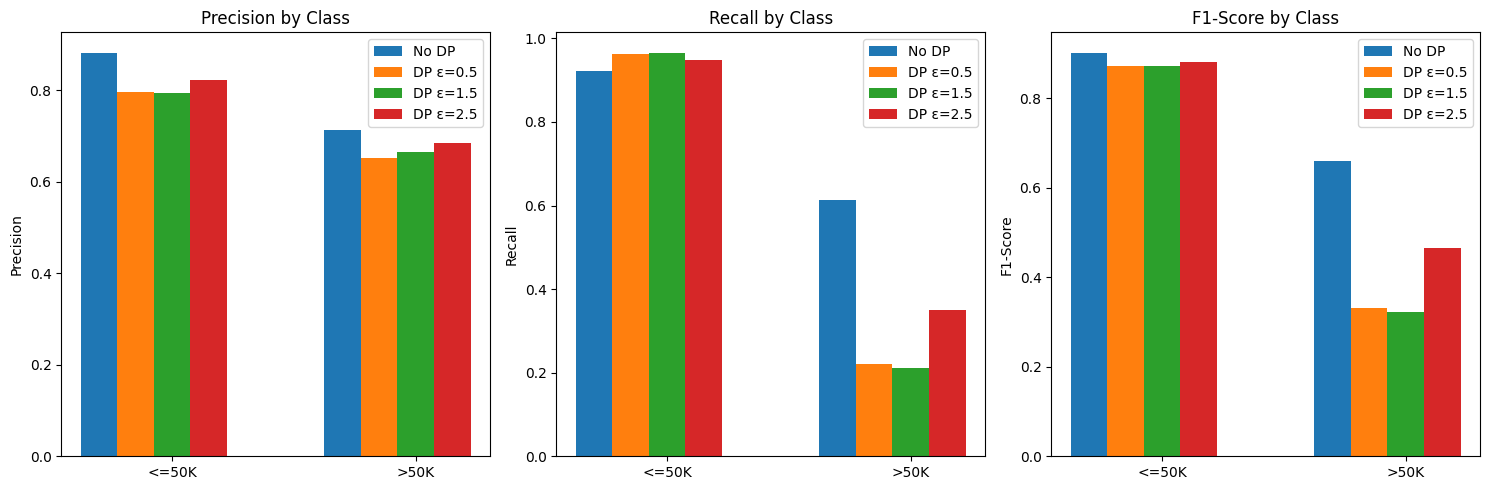

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Get metrics for each class
classes = list(nodp_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

# Prepare data
no_dp_metrics = {
    'precision': [nodp_report[c]['precision'] for c in classes],
    'recall': [nodp_report[c]['recall'] for c in classes],
    'f1-score': [nodp_report[c]['f1-score'] for c in classes]
}

dp_metrics = {
    'precision': [[report[c]['precision'] for c in classes] for report in dp_reports],
    'recall': [[report[c]['recall'] for c in classes] for report in dp_reports],
    'f1-score': [[report[c]['f1-score'] for c in classes] for report in dp_reports]
}

# Plot settings
x = np.arange(len(classes))
width = 0.15
multiplier = 0

# Plot precision
ax1.bar(x + width * multiplier, no_dp_metrics['precision'], width, label='No DP')
multiplier += 1

for i, dp_results in enumerate(dp_metrics['precision']):
    ax1.bar(x + width * multiplier, dp_results, width, label=f'DP ε={epsilons[i]}')
    multiplier += 1

ax1.set_ylabel('Precision')
ax1.set_title('Precision by Class')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(classes)
ax1.legend(loc='best')

# Reset multiplier for recall plot
multiplier = 0

# Plot recall
ax2.bar(x + width * multiplier, no_dp_metrics['recall'], width, label='No DP')
multiplier += 1

for i, dp_results in enumerate(dp_metrics['recall']):
    ax2.bar(x + width * multiplier, dp_results, width, label=f'DP ε={epsilons[i]}')
    multiplier += 1

ax2.set_ylabel('Recall')
ax2.set_title('Recall by Class')
ax2.set_xticks(x + width * 2)
ax2.set_xticklabels(classes)
ax2.legend(loc='best')

# Reset multiplier for f1 plot
multiplier = 0

# Plot f1-score
ax3.bar(x + width * multiplier, no_dp_metrics['f1-score'], width, label='No DP')
multiplier += 1

for i, dp_results in enumerate(dp_metrics['f1-score']):
    ax3.bar(x + width * multiplier, dp_results, width, label=f'DP ε={epsilons[i]}')
    multiplier += 1

ax3.set_ylabel('F1-Score')
ax3.set_title('F1-Score by Class')
ax3.set_xticks(x + width * 2)
ax3.set_xticklabels(classes)
ax3.legend(loc='best')

plt.tight_layout()
plt.show()


**Takeaway:** There's a clear trade-off between privacy and accuracy: more privacy entails giving up on accuracy.

## Fair Synthetic Data

Fair ML aims at creating models that treat different groups of subjects involved in a study equitably. We'll now look into how we can bridge the fairness gap with with fair synthetic data.

In [19]:
hol = df_ho.reset_index(drop=True, inplace=True)

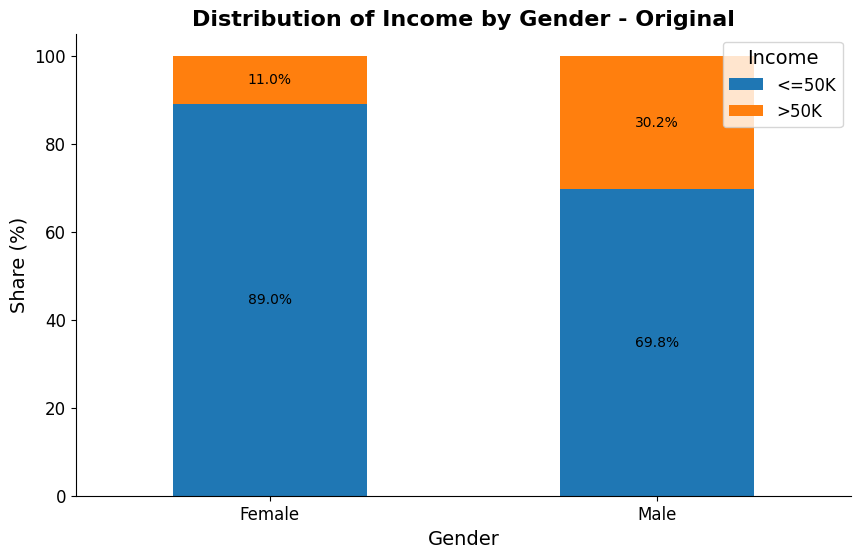

In [20]:
def plot_income_by_gender(df, title):
    # Create a bar plot for the distribution of income for males and females
    plt.figure(figsize=(10, 6))
    income_gender_distribution = df.groupby(["sex", "income"]).size().unstack()
    income_gender_proportions = (
        income_gender_distribution.div(income_gender_distribution.sum(axis=1), axis=0) * 100
    )  # Convert to percentages

    # Customizing the plot
    ax = income_gender_proportions.plot(kind="bar", stacked=True, ax=plt.gca())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Adding title and labels
    plt.title(f"Distribution of Income by Gender - {title}", fontsize=16, weight="bold")
    plt.xlabel("Gender", fontsize=14)
    plt.ylabel("Share (%)", fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Income", fontsize=12, title_fontsize=14, loc="upper right")

    # Adding data labels
    for bar_group in ax.containers:
        ax.bar_label(bar_group, fmt="%.1f%%", label_type="center", fontsize=10)

    plt.show()


plot_income_by_gender(df, title="Original")

### Synthesize Data via MOSTLY AI

The code below will automatically create a Generator using the MOSTLY AI Synthetic Data SDK. Then we will use that Generator to create both, Synthetic dataset and Fair Synthetic dataset with turned on Fairness feature for the target `income` column and sensitive `sex` column.

In [21]:
# Define the fairness configuration
fairness_config = {
    "name": "Fairness Tutorial - Fair Synthetic Data",
    "tables": [
        {
            "name": "census",
            "configuration": {
                "fairness": {
                    "target_column": "income",  # define fairness target
                    "sensitive_columns": ["sex"],  # define sensitive columns
                }
            },
        }
    ],
}

# create fair synthetic data with mitigated bias
fair_sd = mostly.generate(g_no_dp, config=fairness_config)
fair_syn = fair_sd.data()

Created synthetic dataset 0cb371dc-43be-4bf5-8a5e-581aca7b4f83 with generator dc9c5193-0198-4c9e-bd57-02ff99ee8f51

Started synthetic dataset generation

Output()

🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

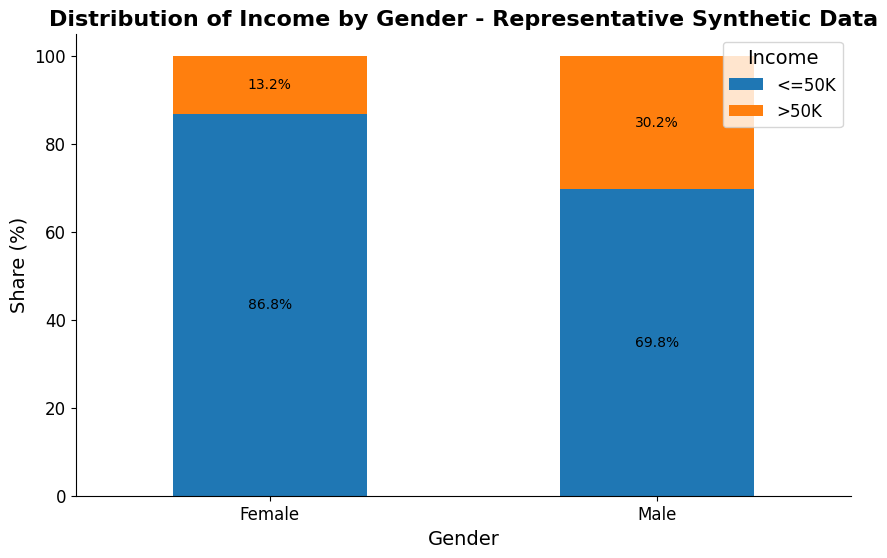

In [22]:
plot_income_by_gender(no_dp_synth_dataset, "Representative Synthetic Data")

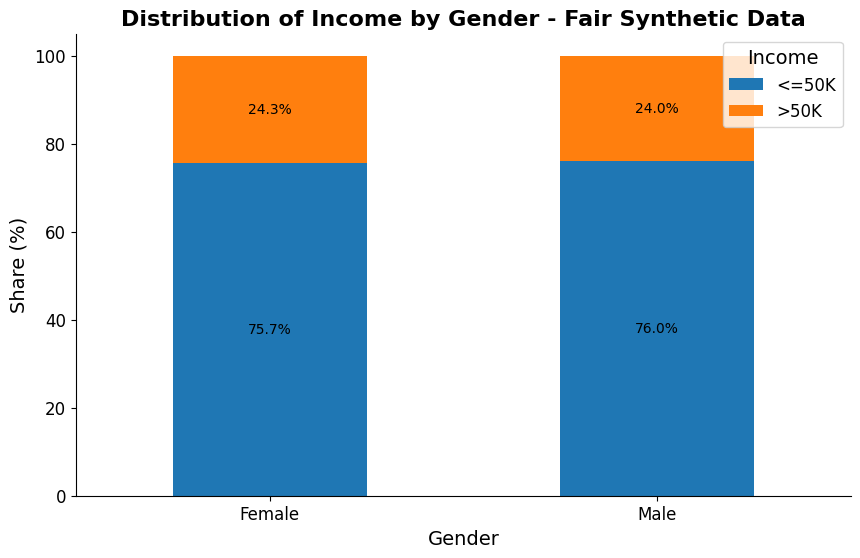

In [23]:
plot_income_by_gender(fair_syn, "Fair Synthetic Data")

Statistical parity difference is mitigated for the fair synthetic dataset, i.e. the proportion of females and mals with high income is comparable.

### Train a Downstream ML Model

We can compare the model prediction using downstream prediction model on the original, synthetic data and fair synthetic data.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [25]:
# Some renaming
trn = df
syn = no_dp_synth_dataset
hol = df_ho

In [26]:
trn_fns = ["original", "synthetic", "fair synthetic"]

y_hol = (hol.pop("income") == ">50K").astype(int)
X_hol = hol

cat_cols = hol.columns[X_hol.dtypes == "object"].tolist()
num_cols = hol.columns[X_hol.dtypes == "int64"].tolist()
ct = ColumnTransformer([("c", OneHotEncoder(handle_unknown="ignore"), cat_cols), ("n", MinMaxScaler(), num_cols)])
model = LogisticRegression(max_iter=500)
pipe = Pipeline(steps=[("t", ct), ("m", model)])

res = []
predicted_probs = pd.DataFrame()
for trn_fn, trn in zip(trn_fns, [trn, syn, fair_syn]):
    y_trn = (trn.pop("income") == ">50K").astype(int)
    X_trn = trn
    pipe.fit(X_trn, y_trn)
    probs = pipe.predict_proba(X_hol)[:, 1]
    predicted_probs[trn_fn] = probs
    res.append(
        {
            "AUC": roc_auc_score(y_hol, probs),
            "Accuracy": accuracy_score(y_hol, probs > 0.5),
            "F1": f1_score(y_hol, probs > 0.5, average="macro"),
            "N": trn.shape[0],
            "fn": trn_fn,
        }
    )

predicted_probs["sex"] = hol["sex"]
predicted_probs["income"] = y_hol

In [27]:
# sort the results based on the model performance:
res_sort = pd.DataFrame(res, index=list(range(len(res))))
predicted_probs["sex"] = hol["sex"]
predicted_probs["income"] = y_hol
res_sort["SP mean difference"] = (res_sort["fn"]).map(
    predicted_probs.groupby(["sex"])[trn_fns].mean().diff().iloc[1, :]
)
res_sort.sort_values(by="SP mean difference", ascending=True)
sorting = res_sort["fn"]
res_sort

,AUC,Accuracy,F1,N,fn,SP mean difference
0,0.897866,0.844099,0.767876,10000,original,0.195997
1,0.888956,0.838571,0.767239,10000,synthetic,0.214179
2,0.875219,0.830484,0.745597,10000,fair synthetic,0.068319


The model performance on synthetic data is comparable to that on the original data, with a similar statistical parity (SP) difference. While fair synthetic data successfully resolves the SP difference, it does so at the expense of downstream model performance, reflected in a slight decreased AUC.

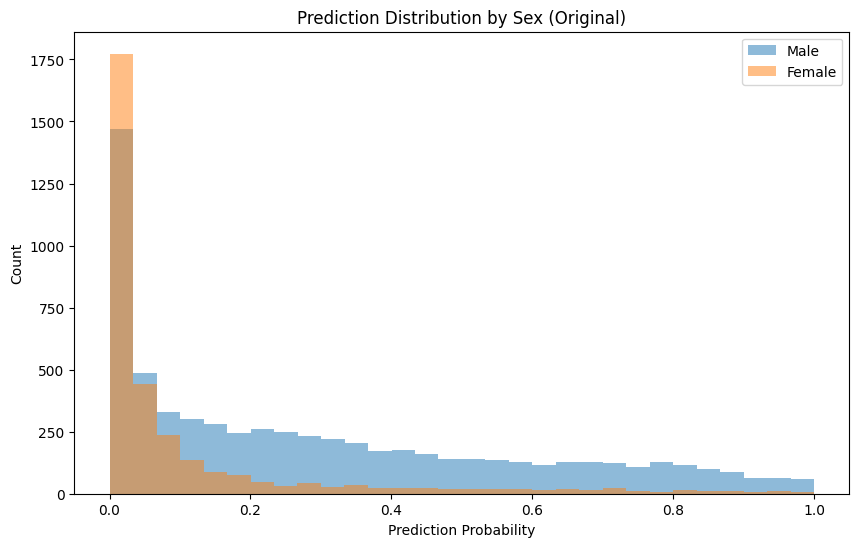

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(predicted_probs[predicted_probs['sex'] == 'Male']['original'], alpha=0.5, label='Male', bins=30)
plt.hist(predicted_probs[predicted_probs['sex'] == 'Female']['original'], alpha=0.5, label='Female', bins=30)
plt.title('Prediction Distribution by Sex (Original)')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

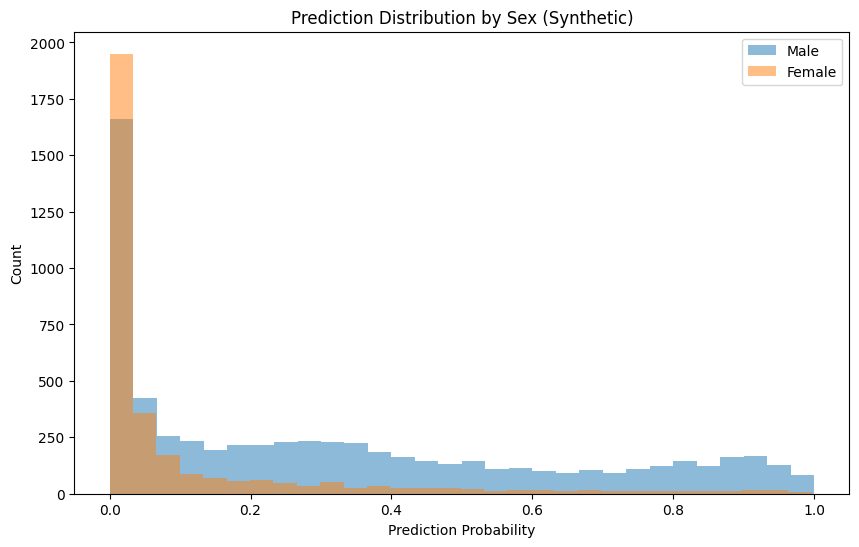

In [29]:

plt.figure(figsize=(10, 6))
plt.hist(predicted_probs[predicted_probs['sex'] == 'Male']['synthetic'], alpha=0.5, label='Male', bins=30)
plt.hist(predicted_probs[predicted_probs['sex'] == 'Female']['synthetic'], alpha=0.5, label='Female', bins=30)
plt.title('Prediction Distribution by Sex (Synthetic)')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

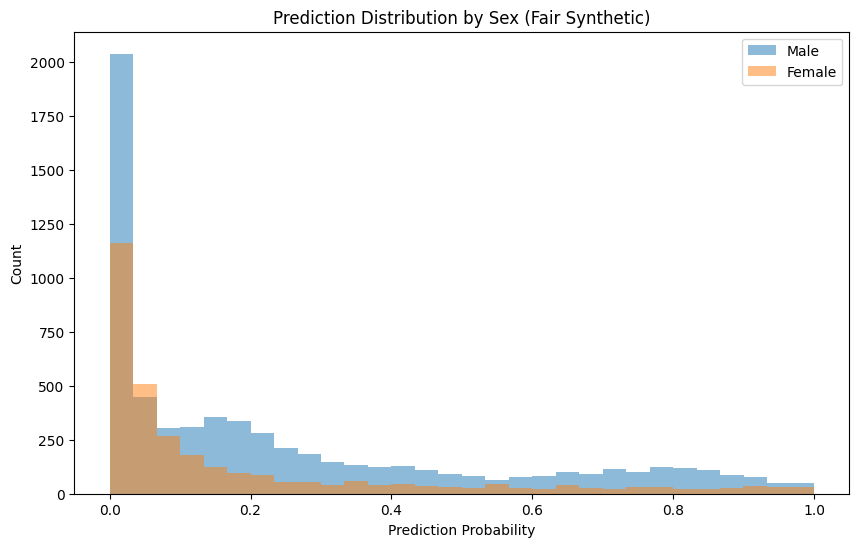

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(predicted_probs[predicted_probs['sex'] == 'Male']['fair synthetic'], alpha=0.5, label='Male', bins=30)
plt.hist(predicted_probs[predicted_probs['sex'] == 'Female']['fair synthetic'], alpha=0.5, label='Female', bins=30)
plt.title('Prediction Distribution by Sex (Fair Synthetic)')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.legend()
plt.show()